# Loading Libraries and Datasets


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import warnings
from sklearn.model_selection import train_test_split
from catboost import CatBoostClassifier, Pool
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import accuracy_score

In [2]:
warnings.filterwarnings('ignore')

In [3]:
train_data=pd.read_csv("/kaggle/input/amex-final/train_data.csv")
test_data=pd.read_csv("/kaggle/input/amex-final/test_data.csv")
primary_data=pd.read_csv("/kaggle/input/amex-final/submission template.csv")
match_data=pd.read_csv("/kaggle/input/amex-final/match_level_scorecard.csv")
bowler_data=pd.read_csv("/kaggle/input/amex-final/bowler_level_scorecard.csv")
batsman_data=pd.read_csv("/kaggle/input/amex-final/batsman_level_scorecard.csv")

# Feature Engineering

Converting match date to correct format


In [4]:
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'], format='%d-%m-%Y')
train_data['match_dt'] = pd.to_datetime(train_data['match_dt'])
match_data['match_dt'] = pd.to_datetime(match_data['match_dt'])
batsman_data['match_dt'] = pd.to_datetime(batsman_data['match_dt'])
bowler_data['match_dt'] = pd.to_datetime(bowler_data['match_dt'])
test_data['match_dt'] = pd.to_datetime(test_data['match_dt'])

In [5]:
# Merge batsman_data and bowler_data with match_data to get season and series_name
batsman_data = batsman_data.merge(match_data[['match id', 'season', 'series_name']], on='match id', how='left')
bowler_data = bowler_data.merge(match_data[['match id', 'season', 'series_name']], on='match id', how='left')

In [6]:
train_data['is_team1_winner'] = train_data['winner_id'] == train_data['team1_id']

# Convert the boolean column to integer (0 for False, 1 for True)
train_data['is_team1_winner'] = train_data['is_team1_winner'].astype(int)

In [7]:
train_data['is_team1_winner'] = train_data['winner_id'] == train_data['team1_id']
train_data['is_team1_winner']

0       False
1        True
2        True
3        True
4       False
        ...  
1150    False
1151    False
1152    False
1153    False
1154    False
Name: is_team1_winner, Length: 1155, dtype: bool

In [8]:
train_data[['team1_id','winner_id']]

,team1_id,winner_id
0,11283,12634.0
1,20,20.0
2,10576,10576.0
3,36084,36084.0
4,30407,48341.0
...,...,...
1150,30407,NaN
1151,36014,NaN
1152,30393,NaN
1153,36014,NaN


In [9]:
import pandas as pd

# Assuming train_data, batsman_data, bowler_data, and match_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]



# Add new columns to train_data for max total runs and max wickets
train_data['team1_max_total_runs_before_same_series'] = 0
train_data['team1_max_wickets_before_same_series'] = 0

# Iterate through each match in train_data
for index, match in train_data.iterrows():
    match_date = match['match_dt']
    season = match['season']
    series_name = match['series_name']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date in the same season and series
    previous_batsman_data = batsman_data[
        (batsman_data['match_dt'] < match_date) &
        (batsman_data['season'] == season) &
        (batsman_data['series_name'] == series_name)
    ]
    previous_bowler_data = bowler_data[
        (bowler_data['match_dt'] < match_date) &
        (bowler_data['season'] == season) &
        (bowler_data['series_name'] == series_name)
    ]
    
    # Iterate through each player in team1_roster
    for player_id in team1_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    train_data.at[index, 'team1_max_total_runs_before_same_series'] = max_total_runs
    train_data.at[index, 'team1_max_wickets_before_same_series'] = max_wickets


In [10]:
import pandas as pd

# Assuming train_data, batsman_data, bowler_data, and match_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]


# Add new columns to train_data for max total runs and max wickets
train_data['team2_max_total_runs_before_same_series'] = 0
train_data['team2_max_wickets_before_same_series'] = 0

# Iterate through each match in train_data
for index, match in train_data.iterrows():
    match_date = match['match_dt']
    season = match['season']
    series_name = match['series_name']
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date in the same season and series
    previous_batsman_data = batsman_data[
        (batsman_data['match_dt'] < match_date) &
        (batsman_data['season'] == season) &
        (batsman_data['series_name'] == series_name)
    ]
    previous_bowler_data = bowler_data[
        (bowler_data['match_dt'] < match_date) &
        (bowler_data['season'] == season) &
        (bowler_data['series_name'] == series_name)
    ]
    
    # Iterate through each player in team1_roster
    for player_id in team2_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    train_data.at[index, 'team2_max_total_runs_before_same_series'] = max_total_runs
    train_data.at[index, 'team2_max_wickets_before_same_series'] = max_wickets


In [11]:
import pandas as pd

# Assuming train_data, batsman_data, bowler_data, and match_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]


# Add new columns to train_data for max total runs and max wickets
test_data['team1_max_total_runs_before_same_series'] = 0
test_data['team1_max_wickets_before_same_series'] = 0

# Iterate through each match in train_data
for index, match in test_data.iterrows():
    match_date = match['match_dt']
    season = match['season']
    series_name = match['series_name']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date in the same season and series
    previous_batsman_data = batsman_data[
        (batsman_data['match_dt'] < match_date) &
        (batsman_data['season'] == season) &
        (batsman_data['series_name'] == series_name)
    ]
    previous_bowler_data = bowler_data[
        (bowler_data['match_dt'] < match_date) &
        (bowler_data['season'] == season) &
        (bowler_data['series_name'] == series_name)
    ]
    
    # Iterate through each player in team1_roster
    for player_id in team1_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    test_data.at[index, 'team1_max_total_runs_before_same_series'] = max_total_runs
    test_data.at[index, 'team1_max_wickets_before_same_series'] = max_wickets


In [12]:
import pandas as pd

# Assuming train_data, batsman_data, bowler_data, and match_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]


# Add new columns to train_data for max total runs and max wickets
test_data['team2_max_total_runs_before_same_series'] = 0
test_data['team2_max_wickets_before_same_series'] = 0

# Iterate through each match in train_data
for index, match in test_data.iterrows():
    match_date = match['match_dt']
    season = match['season']
    series_name = match['series_name']
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date in the same season and series
    previous_batsman_data = batsman_data[
        (batsman_data['match_dt'] < match_date) &
        (batsman_data['season'] == season) &
        (batsman_data['series_name'] == series_name)
    ]
    previous_bowler_data = bowler_data[
        (bowler_data['match_dt'] < match_date) &
        (bowler_data['season'] == season) &
        (bowler_data['series_name'] == series_name)
    ]
    
    # Iterate through each player in team1_roster
    for player_id in team2_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    test_data.at[index, 'team2_max_total_runs_before_same_series'] = max_total_runs
    test_data.at[index, 'team2_max_wickets_before_same_series'] = max_wickets


In [13]:
import pandas as pd

# Assuming train_data, batsman_data, and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Add new columns to train_data for max total runs and max wickets
train_data['team1_max_total_runs_before'] = 0
train_data['team1_max_wickets_before'] = 0

# Iterate through each match in train_data
for index, match in train_data.iterrows():
    match_date = match['match_dt']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date
    previous_batsman_data = batsman_data[batsman_data['match_dt'] < match_date]
    previous_bowler_data = bowler_data[bowler_data['match_dt'] < match_date]
    
    # Iterate through each player in team1_roster
    for player_id in team1_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    train_data.at[index, 'team1_max_total_runs_before'] = max_total_runs
    train_data.at[index, 'team1_max_wickets_before'] = max_wickets



In [14]:
import pandas as pd

# Assuming train_data, batsman_data, and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Add new columns to train_data for max total runs and max wickets
train_data['team2_max_total_runs_before'] = 0
train_data['team2_max_wickets_before'] = 0

# Iterate through each match in train_data
for index, match in train_data.iterrows():
    match_date = match['match_dt']
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date
    previous_batsman_data = batsman_data[batsman_data['match_dt'] < match_date]
    previous_bowler_data = bowler_data[bowler_data['match_dt'] < match_date]
    
    # Iterate through each player in team1_roster
    for player_id in team2_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    train_data.at[index, 'team2_max_total_runs_before'] = max_total_runs
    train_data.at[index, 'team2_max_wickets_before'] = max_wickets



In [15]:
import pandas as pd

# Assuming train_data, batsman_data, and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Add new columns to train_data for max total runs and max wickets
test_data['team1_max_total_runs_before'] = 0
test_data['team1_max_wickets_before'] = 0

# Iterate through each match in train_data
for index, match in test_data.iterrows():
    match_date = match['match_dt']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date
    previous_batsman_data = batsman_data[batsman_data['match_dt'] < match_date]
    previous_bowler_data = bowler_data[bowler_data['match_dt'] < match_date]
    
    # Iterate through each player in team1_roster
    for player_id in team1_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    test_data.at[index, 'team1_max_total_runs_before'] = max_total_runs
    test_data.at[index, 'team1_max_wickets_before'] = max_wickets



In [16]:
import pandas as pd

# Assuming train_data, batsman_data, and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Add new columns to train_data for max total runs and max wickets
test_data['team2_max_total_runs_before'] = 0
test_data['team2_max_wickets_before'] = 0

# Iterate through each match in train_data
for index, match in test_data.iterrows():
    match_date = match['match_dt']
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    max_total_runs = 0
    max_wickets = 0
    
    # Filter batsman_data and bowler_data for matches before the current match date
    previous_batsman_data = batsman_data[batsman_data['match_dt'] < match_date]
    previous_bowler_data = bowler_data[bowler_data['match_dt'] < match_date]
    
    # Iterate through each player in team1_roster
    for player_id in team2_roster:
        # Calculate total runs for the player
        player_total_runs = previous_batsman_data[previous_batsman_data['batsman_id'] == player_id]['runs'].sum()
        max_total_runs = max(max_total_runs, player_total_runs)
        
        # Calculate total wickets for the player
        player_total_wickets = previous_bowler_data[previous_bowler_data['bowler_id'] == player_id]['wicket_count'].sum()
        max_wickets = max(max_wickets, player_total_wickets)
    
    # Update the train_data with the calculated values
    test_data.at[index, 'team2_max_total_runs_before'] = max_total_runs
    test_data.at[index, 'team2_max_wickets_before'] = max_wickets



In [17]:
import pandas as pd

# Load your data here
# Assuming train_data and batsman_data are already defined and loaded

# Step 1: Extract Bowling Style from bowler_details
def extract_bowling_style(detail):
    if pd.notna(detail):
        return detail.split(':')[-1]
    return None

batsman_data['bowling_style'] = batsman_data['bowler_details'].apply(extract_bowling_style)

# Get all unique bowling styles
unique_bowling_styles = batsman_data['bowling_style'].dropna().unique()

# Initialize a dictionary with all bowling styles set to 0
all_bowler_styles = {style: 0 for style in unique_bowling_styles}

# Step 2: Sort the data by match date to ensure we process matches chronologically
batsman_data = batsman_data.sort_values(by='match_dt')
# train_data = train_data.sort_values(by='match_dt')

# Initialize columns for opposite team bowler counts
train_data['max_out_team1_avg_product_before_match'] = 0

# Function to calculate maximum dismissals by bowler type for each batsman
def calculate_max_dismissals(batsman_id, previous_matches):
    bowler_counts = previous_matches.loc[previous_matches['batsman_id'] == batsman_id, 'bowling_style'].value_counts()
    if not bowler_counts.empty:
        max_dismissals = bowler_counts.max()
        bowler_style = bowler_counts.idxmax()
        return max_dismissals, bowler_style
    return 0, None

# Process each match in chronological order
for idx, match in train_data.iterrows():
    match_id = match['match id']
    match_date = match['match_dt']
    team1_roster = match['team1_roster_ids'].split(':')
    team2_roster = match['team2_roster_ids'].split(':')

    # Ensure player IDs are correctly formatted and converted to integers
    team1_roster = [int(float(player_id.strip())) for player_id in team1_roster if player_id.strip()]
    team2_roster = [int(float(player_id.strip())) for player_id in team2_roster if player_id.strip()]

    # Initialize bowler counts with all bowler styles set to 0
    team1_bowlers_count = all_bowler_styles.copy()
    team2_bowlers_count = all_bowler_styles.copy()

    # Update bowler counts based on the roster
#     for bowler in team1_roster:
#         bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
#         if len(bowler_style) > 0 and bowler_style[0] is not None:
#             bowler_style = bowler_style[0]
#             team1_bowlers_count[bowler_style] += 1

    for bowler in team2_roster:
        bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
        if len(bowler_style) > 0 and bowler_style[0] is not None:
            bowler_style = bowler_style[0]
            team2_bowlers_count[bowler_style] += 1

    # Filter batsman_data to include only matches played before the current match
    previous_matches = batsman_data[batsman_data['match_dt'] < match_date]

    # Calculate product for each batsman in the match
    batsman_products = {}
    bowler_count={}
    for batsman in team1_roster:
        batsman_id = batsman
        max_dismissals, max_bowler_style = calculate_max_dismissals(batsman_id, previous_matches)
        opposite_bowler_count = team2_bowlers_count.get(max_bowler_style, 0)
        product = max_dismissals * opposite_bowler_count
        batsman_products[batsman_id] = product
        bowler_count[batsman_id]=opposite_bowler_count
#         if max_bowler_style:
#             if batsman in team1_roster:
#                 opposite_bowler_count = team2_bowlers_count.get(max_bowler_style, 0)
#             else:
#                 opposite_bowler_count = team1_bowlers_count.get(max_bowler_style, 0)
            
#             # Calculate the product with the condition
#             product = max_dismissals * opposite_bowler_count
#             batsman_products[batsman_id] = product

    # Calculate the average product for all batsmen in the match
    avg_product_all_batsmen = sum(batsman_products.values()) / len(batsman_products) if batsman_products else 0
    train_data.at[idx, 'max_out_team1_avg_product_before_match'] = avg_product_all_batsmen
    train_data.at[idx,'opposite_bowler_count_team1']=sum(bowler_count.values())/len(bowler_count) if bowler_count else 0


In [18]:
import pandas as pd

# Load your data here
# Assuming train_data and batsman_data are already defined and loaded

# Step 1: Extract Bowling Style from bowler_details
def extract_bowling_style(detail):
    if pd.notna(detail):
        return detail.split(':')[-1]
    return None

batsman_data['bowling_style'] = batsman_data['bowler_details'].apply(extract_bowling_style)

# Get all unique bowling styles
unique_bowling_styles = batsman_data['bowling_style'].dropna().unique()

# Initialize a dictionary with all bowling styles set to 0
all_bowler_styles = {style: 0 for style in unique_bowling_styles}

# Step 2: Sort the data by match date to ensure we process matches chronologically
batsman_data = batsman_data.sort_values(by='match_dt')
# train_data = train_data.sort_values(by='match_dt')

# Initialize columns for opposite team bowler counts
train_data['max_out_team2_avg_product_before_match'] = 0

# Function to calculate maximum dismissals by bowler type for each batsman
def calculate_max_dismissals(batsman_id, previous_matches):
    bowler_counts = previous_matches.loc[previous_matches['batsman_id'] == batsman_id, 'bowling_style'].value_counts()
    if not bowler_counts.empty:
        max_dismissals = bowler_counts.max()
        bowler_style = bowler_counts.idxmax()
        return max_dismissals, bowler_style
    return 0, None

# Process each match in chronological order
for idx, match in train_data.iterrows():
    match_id = match['match id']
    match_date = match['match_dt']
    team1_roster = match['team1_roster_ids'].split(':')
    team2_roster = match['team2_roster_ids'].split(':')

    # Ensure player IDs are correctly formatted and converted to integers
    team1_roster = [int(float(player_id.strip())) for player_id in team1_roster if player_id.strip()]
    team2_roster = [int(float(player_id.strip())) for player_id in team2_roster if player_id.strip()]

    # Initialize bowler counts with all bowler styles set to 0
    team1_bowlers_count = all_bowler_styles.copy()
    team2_bowlers_count = all_bowler_styles.copy()

    # Update bowler counts based on the roster
#     for bowler in team1_roster:
#         bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
#         if len(bowler_style) > 0 and bowler_style[0] is not None:
#             bowler_style = bowler_style[0]
#             team1_bowlers_count[bowler_style] += 1

    for bowler in team1_roster:
        bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
        if len(bowler_style) > 0 and bowler_style[0] is not None:
            bowler_style = bowler_style[0]
            team1_bowlers_count[bowler_style] += 1

    # Filter batsman_data to include only matches played before the current match
    previous_matches = batsman_data[batsman_data['match_dt'] < match_date]

    # Calculate product for each batsman in the match
    batsman_products = {}
    bowler_count={}
    for batsman in team2_roster:
        batsman_id = batsman
        max_dismissals, max_bowler_style = calculate_max_dismissals(batsman_id, previous_matches)
        opposite_bowler_count = team1_bowlers_count.get(max_bowler_style, 0)
        product = max_dismissals * opposite_bowler_count
        batsman_products[batsman_id] = product
        bowler_count[batsman_id]=opposite_bowler_count
#         if max_bowler_style:
#             if batsman in team1_roster:
#                 opposite_bowler_count = team2_bowlers_count.get(max_bowler_style, 0)
#             else:
#                 opposite_bowler_count = team1_bowlers_count.get(max_bowler_style, 0)
            
#             # Calculate the product with the condition
#             product = max_dismissals * opposite_bowler_count
#             batsman_products[batsman_id] = product

    # Calculate the average product for all batsmen in the match
    avg_product_all_batsmen = sum(batsman_products.values()) / len(batsman_products) if batsman_products else 0
    train_data.at[idx, 'max_out_team2_avg_product_before_match'] = avg_product_all_batsmen
    train_data.at[idx,'opposite_bowler_count_team2']=sum(bowler_count.values())/len(bowler_count) if bowler_count else 0



In [19]:
import pandas as pd

# Load your data here
# Assuming train_data and batsman_data are already defined and loaded

# Step 1: Extract Bowling Style from bowler_details
def extract_bowling_style(detail):
    if pd.notna(detail):
        return detail.split(':')[-1]
    return None

batsman_data['bowling_style'] = batsman_data['bowler_details'].apply(extract_bowling_style)

# Get all unique bowling styles
unique_bowling_styles = batsman_data['bowling_style'].dropna().unique()

# Initialize a dictionary with all bowling styles set to 0
all_bowler_styles = {style: 0 for style in unique_bowling_styles}

# Step 2: Sort the data by match date to ensure we process matches chronologically
batsman_data = batsman_data.sort_values(by='match_dt')
# test_data = test_data.sort_values(by='match_dt')

# Initialize columns for opposite team bowler counts
test_data['max_out_team1_avg_product_before_match'] = 0

# Function to calculate maximum dismissals by bowler type for each batsman
def calculate_max_dismissals(batsman_id, previous_matches):
    bowler_counts = previous_matches.loc[previous_matches['batsman_id'] == batsman_id, 'bowling_style'].value_counts()
    if not bowler_counts.empty:
        max_dismissals = bowler_counts.max()
        bowler_style = bowler_counts.idxmax()
        return max_dismissals, bowler_style
    return 0, None

# Process each match in chronological order
for idx, match in test_data.iterrows():
    match_id = match['match id']
    match_date = match['match_dt']
    team1_roster = match['team1_roster_ids'].split(':')
    team2_roster = match['team2_roster_ids'].split(':')

    # Ensure player IDs are correctly formatted and converted to integers
    team1_roster = [int(float(player_id.strip())) for player_id in team1_roster if player_id.strip()]
    team2_roster = [int(float(player_id.strip())) for player_id in team2_roster if player_id.strip()]

    # Initialize bowler counts with all bowler styles set to 0
    team1_bowlers_count = all_bowler_styles.copy()
    team2_bowlers_count = all_bowler_styles.copy()

    # Update bowler counts based on the roster
#     for bowler in team1_roster:
#         bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
#         if len(bowler_style) > 0 and bowler_style[0] is not None:
#             bowler_style = bowler_style[0]
#             team1_bowlers_count[bowler_style] += 1

    for bowler in team2_roster:
        bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
        if len(bowler_style) > 0 and bowler_style[0] is not None:
            bowler_style = bowler_style[0]
            team2_bowlers_count[bowler_style] += 1

    # Filter batsman_data to include only matches played before the current match
    previous_matches = batsman_data[batsman_data['match_dt'] < match_date]

    # Calculate product for each batsman in the match
    batsman_products = {}
    bowler_count={}
    for batsman in team1_roster:
        batsman_id = batsman
        max_dismissals, max_bowler_style = calculate_max_dismissals(batsman_id, previous_matches)
        opposite_bowler_count = team2_bowlers_count.get(max_bowler_style, 0)
        product = max_dismissals * opposite_bowler_count
        batsman_products[batsman_id] = product
        bowler_count[batsman_id]=opposite_bowler_count
#         if max_bowler_style:
#             if batsman in team1_roster:
#                 opposite_bowler_count = team2_bowlers_count.get(max_bowler_style, 0)
#             else:
#                 opposite_bowler_count = team1_bowlers_count.get(max_bowler_style, 0)
            
#             # Calculate the product with the condition
#             product = max_dismissals * opposite_bowler_count
#             batsman_products[batsman_id] = product

    # Calculate the average product for all batsmen in the match
    avg_product_all_batsmen = sum(batsman_products.values()) / len(batsman_products) if batsman_products else 0
    test_data.at[idx, 'max_out_team1_avg_product_before_match'] = avg_product_all_batsmen
    test_data.at[idx,'opposite_bowler_count_team1']=sum(bowler_count.values())/len(bowler_count) if bowler_count else 0


In [20]:
import pandas as pd

# Load your data here
# Assuming train_data and batsman_data are already defined and loaded

# Step 1: Extract Bowling Style from bowler_details
def extract_bowling_style(detail):
    if pd.notna(detail):
        return detail.split(':')[-1]
    return None

batsman_data['bowling_style'] = batsman_data['bowler_details'].apply(extract_bowling_style)

# Get all unique bowling styles
unique_bowling_styles = batsman_data['bowling_style'].dropna().unique()

# Initialize a dictionary with all bowling styles set to 0
all_bowler_styles = {style: 0 for style in unique_bowling_styles}

# Step 2: Sort the data by match date to ensure we process matches chronologically
batsman_data = batsman_data.sort_values(by='match_dt')
# test_data = test_data.sort_values(by='match_dt')

# Initialize columns for opposite team bowler counts
test_data['max_out_team2_avg_product_before_match'] = 0

# Function to calculate maximum dismissals by bowler type for each batsman
def calculate_max_dismissals(batsman_id, previous_matches):
    bowler_counts = previous_matches.loc[previous_matches['batsman_id'] == batsman_id, 'bowling_style'].value_counts()
    if not bowler_counts.empty:
        max_dismissals = bowler_counts.max()
        bowler_style = bowler_counts.idxmax()
        return max_dismissals, bowler_style
    return 0, None

# Process each match in chronological order
for idx, match in test_data.iterrows():
    match_id = match['match id']
    match_date = match['match_dt']
    team1_roster = match['team1_roster_ids'].split(':')
    team2_roster = match['team2_roster_ids'].split(':')

    # Ensure player IDs are correctly formatted and converted to integers
    team1_roster = [int(float(player_id.strip())) for player_id in team1_roster if player_id.strip()]
    team2_roster = [int(float(player_id.strip())) for player_id in team2_roster if player_id.strip()]

    # Initialize bowler counts with all bowler styles set to 0
    team1_bowlers_count = all_bowler_styles.copy()
    team2_bowlers_count = all_bowler_styles.copy()

    # Update bowler counts based on the roster
#     for bowler in team1_roster:
#         bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
#         if len(bowler_style) > 0 and bowler_style[0] is not None:
#             bowler_style = bowler_style[0]
#             team1_bowlers_count[bowler_style] += 1

    for bowler in team1_roster:
        bowler_style = batsman_data.loc[batsman_data['batsman_id'] == bowler, 'bowling_style'].values
        if len(bowler_style) > 0 and bowler_style[0] is not None:
            bowler_style = bowler_style[0]
            team1_bowlers_count[bowler_style] += 1

    # Filter batsman_data to include only matches played before the current match
    previous_matches = batsman_data[batsman_data['match_dt'] < match_date]

    # Calculate product for each batsman in the match
    batsman_products = {}
    bowler_count={}
    for batsman in team2_roster:
        batsman_id = batsman
        max_dismissals, max_bowler_style = calculate_max_dismissals(batsman_id, previous_matches)
        opposite_bowler_count = team1_bowlers_count.get(max_bowler_style, 0)
        product = max_dismissals * opposite_bowler_count
        batsman_products[batsman_id] = product
        bowler_count[batsman_id]=opposite_bowler_count
#         if max_bowler_style:
#             if batsman in team1_roster:
#                 opposite_bowler_count = team2_bowlers_count.get(max_bowler_style, 0)
#             else:
#                 opposite_bowler_count = team1_bowlers_count.get(max_bowler_style, 0)
            
#             # Calculate the product with the condition
#             product = max_dismissals * opposite_bowler_count
#             batsman_products[batsman_id] = product

    # Calculate the average product for all batsmen in the match
    avg_product_all_batsmen = sum(batsman_products.values()) / len(batsman_products) if batsman_products else 0
    test_data.at[idx, 'max_out_team2_avg_product_before_match'] = avg_product_all_batsmen
    test_data.at[idx,'opposite_bowler_count_team2']=sum(bowler_count.values())/len(bowler_count) if bowler_count else 0


In [21]:
def calculate_win_percentage(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    wins = last_n_matches[last_n_matches['winner_id'] == team_id].shape[0]
    total_matches = last_n_matches.shape[0]
    return wins / total_matches if total_matches > 0 else 0

In [22]:
train_data['team1_winp_last5'] = train_data.apply(lambda row: calculate_win_percentage(row, 'team1_id',5), axis=1)
train_data['team2_winp_last5'] = train_data.apply(lambda row: calculate_win_percentage(row, 'team2_id',5), axis=1)
test_data['team1_winp_last5'] = test_data.apply(lambda row: calculate_win_percentage(row, 'team1_id',5), axis=1)
test_data['team2_winp_last5'] = test_data.apply(lambda row: calculate_win_percentage(row, 'team2_id',5), axis=1)


In [23]:
import pandas as pd

# Assuming match_data is your historical matches DataFrame and test_data is your test dataset

def calculate_win_percentage_at_ground(row, team_id_input):
    match_dt = row['match_dt']
    team_id = row[team_id_input]
    ground_id = row['ground_id']  # Assuming there's a 'ground_id' in the row

    # Filter matches involving the team before the match date at the specific ground
    team_matches = match_data[((match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)) & (match_data['ground_id'] == ground_id)].sort_values(by='match_dt', ascending=False)
   
    # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
   
    wins = team_matches_before_date[team_matches_before_date['winner_id'] == team_id].shape[0]
    total_matches = team_matches_before_date.shape[0]
   
    return wins / total_matches if total_matches > 0 else 0

# Apply the function to the test data
train_data['team1_winp_at_ground'] = train_data.apply(lambda row: calculate_win_percentage_at_ground(row, 'team1_id'), axis=1)
test_data['team1_winp_at_ground'] = test_data.apply(lambda row: calculate_win_percentage_at_ground(row, 'team1_id'), axis=1)

# You can also calculate for team2 if needed
train_data['team2_winp_at_ground'] = train_data.apply(lambda row: calculate_win_percentage_at_ground(row, 'team2_id'), axis=1)
test_data['team2_winp_at_ground'] = test_data.apply(lambda row: calculate_win_percentage_at_ground(row, 'team2_id'), axis=1)

In [24]:
train_data[['match id','team1_winp_at_ground']].iloc[947:950]

,match id,team1_winp_at_ground
947,9433633,0.000000
948,9272619,0.333333
949,9086958,0.000000


In [25]:
# avg runs calculations
def calculate_avg_runs(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    
    avg_score_last_n_matches = last_n_matches['inning1_runs'].mean() if row['team1_id'] == team_id else last_n_matches['inning2_runs'].mean()
    return avg_score_last_n_matches
    

In [26]:
train_data['team2_avg_runs_last15'] = train_data.apply(lambda row: calculate_avg_runs(row, 'team2_id',15), axis=1)
test_data['team2_avg_runs_last15'] = test_data.apply(lambda row: calculate_avg_runs(row, 'team2_id',15), axis=1)

In [27]:
def calculate_avg_wickets(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    
    avg_score_last_n_matches = last_n_matches['inning1_wickets'].mean() if row['team1_id'] == team_id else last_n_matches['inning2_wickets'].mean()
    return avg_score_last_n_matches

In [28]:
train_data['team1_avg_wickets_last15'] = train_data.apply(lambda row: calculate_avg_wickets(row, 'team1_id',15), axis=1)
train_data['team2_avg_wickets_last15'] = train_data.apply(lambda row: calculate_avg_wickets(row, 'team2_id',15), axis=1)
test_data['team1_avg_wickets_last15'] = test_data.apply(lambda row: calculate_avg_wickets(row, 'team1_id',15), axis=1)
test_data['team2_avg_wickets_last15'] = test_data.apply(lambda row: calculate_avg_wickets(row, 'team2_id',15), axis=1)

In [29]:
# avg run rate calculations
def calculate_run_rate(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    
    avg_score_last_n_matches = last_n_matches['inning1_runs'].mean()*6/last_n_matches['inning1_balls'].mean() if row['team1_id'] == team_id else last_n_matches['inning2_runs'].mean()*6/last_n_matches['inning2_balls'].mean()
    return avg_score_last_n_matches

In [30]:
train_data['team1_avg_run_rate_last15'] = train_data.apply(lambda row: calculate_run_rate(row, 'team1_id',15), axis=1)
train_data['team2_avg_run_rate_last15'] = train_data.apply(lambda row: calculate_run_rate(row, 'team2_id',15), axis=1)
test_data['team1_avg_run_rate_last15'] = test_data.apply(lambda row: calculate_run_rate(row, 'team1_id',15), axis=1)
test_data['team2_avg_run_rate_last15'] = test_data.apply(lambda row: calculate_run_rate(row, 'team2_id',15), axis=1)

In [31]:
# avg run rate calculations
def calculate_wicket_rate(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    
    avg_score_last_n_matches = last_n_matches['inning1_wickets'].mean()*6/last_n_matches['inning1_balls'].mean() if row['team1_id'] == team_id else last_n_matches['inning2_wickets'].mean()*6/last_n_matches['inning2_balls'].mean()
    return avg_score_last_n_matches

In [32]:
train_data['team1_avg_wicket_rate_last15'] = train_data.apply(lambda row: calculate_wicket_rate(row, 'team1_id',15), axis=1)
train_data['team2_avg_wicket_rate_last15'] = train_data.apply(lambda row: calculate_wicket_rate(row, 'team2_id',15), axis=1)
test_data['team1_avg_wicket_rate_last15'] = test_data.apply(lambda row: calculate_wicket_rate(row, 'team1_id',15), axis=1)
test_data['team2_avg_wicket_rate_last15'] = test_data.apply(lambda row: calculate_wicket_rate(row, 'team2_id',15), axis=1)

In [33]:
# avg batting and bowling average  calculations
def calculate_bat_avg(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    
    bat_avg_score_last_n_matches = last_n_matches['inning1_runs'].mean()/last_n_matches['inning1_wickets'].mean() if row['team1_id'] == team_id else last_n_matches['inning2_runs'].mean()/last_n_matches['inning2_wickets'].mean()
    
    return bat_avg_score_last_n_matches

In [34]:
train_data['team1_avg_bat_last5'] = train_data.apply(lambda row: calculate_bat_avg(row, 'team1_id',5), axis=1)
train_data['team2_avg_bat_last5'] = train_data.apply(lambda row: calculate_bat_avg(row, 'team2_id',5), axis=1)
test_data['team1_avg_bat_last5'] = test_data.apply(lambda row: calculate_bat_avg(row, 'team1_id',5), axis=1)
test_data['team2_avg_bat_last5'] = test_data.apply(lambda row: calculate_bat_avg(row, 'team2_id',5), axis=1)

In [35]:
def calculate_bowl_avg(row,team_id_input, num_matches):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    # Filter matches involving the team before the end date
    # Filter match_data for matches where the team played as either team1 or team2
    team_matches = match_data[(match_data['team1_id'] == team_id) | (match_data['team2_id'] == team_id)]
 # Filter for matches before the current match date
    team_matches_before_date = team_matches[team_matches['match_dt'] < match_dt]
    #Select the last n matches
    last_n_matches = team_matches_before_date.tail(num_matches)
#     print(last_n_matches['match_dt'])
    
    bowl_avg_score_last_n_matches = last_n_matches['inning1_runs'].mean()/last_n_matches['inning1_wickets'].mean() if row['team2_id'] == team_id else last_n_matches['inning2_runs'].mean()/last_n_matches['inning2_wickets'].mean()
    
    return bowl_avg_score_last_n_matches

In [36]:
train_data['team1_avg_bowl_last5'] = train_data.apply(lambda row: calculate_bowl_avg(row, 'team1_id',5), axis=1)
train_data['team2_avg_bowl_last5'] = train_data.apply(lambda row: calculate_bowl_avg(row, 'team2_id',5), axis=1)
test_data['team1_avg_bowl_last5'] = test_data.apply(lambda row: calculate_bowl_avg(row, 'team1_id',5), axis=1)
test_data['team2_avg_bowl_last5'] = test_data.apply(lambda row: calculate_bowl_avg(row, 'team2_id',5), axis=1)

In [37]:
def preprocess_roster_ids(roster_ids):
    return [int(float(id_)) for id_ in roster_ids.split(':')]
def calculate_centuries_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = batsman_data[
        (batsman_data['batsman_id'].isin(player_ids)) & 
        (batsman_data['runs'] >= 100) & 
        (batsman_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [38]:
train_data['team1_playing_players_centuries_before'] = train_data.apply(lambda row: calculate_centuries_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_centuries_before'] = train_data.apply(lambda row: calculate_centuries_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_centuries_before'] = test_data.apply(lambda row: calculate_centuries_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_centuries_before'] = test_data.apply(lambda row: calculate_centuries_before(row, 'team2_id'), axis=1)

In [39]:
def preprocess_roster_ids(roster_ids):
    return [int(float(id_)) for id_ in roster_ids.split(':')]
def calculate_80_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = batsman_data[
        (batsman_data['batsman_id'].isin(player_ids)) & 
        (batsman_data['runs'] >= 80) & 
        (batsman_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [40]:
train_data['team1_playing_players_80s_before'] = train_data.apply(lambda row: calculate_80_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_80s_before'] = train_data.apply(lambda row: calculate_80_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_80s_before'] = test_data.apply(lambda row: calculate_80_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_80s_before'] = test_data.apply(lambda row: calculate_80_before(row, 'team2_id'), axis=1)

In [41]:
def preprocess_roster_ids(roster_ids):
    return [int(float(id_)) for id_ in roster_ids.split(':')]
def calculate_90_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = batsman_data[
        (batsman_data['batsman_id'].isin(player_ids)) & 
        (batsman_data['runs'] >= 90) & 
        (batsman_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [42]:
train_data['team1_playing_players_90s_before'] = train_data.apply(lambda row: calculate_90_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_90s_before'] = train_data.apply(lambda row: calculate_90_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_90s_before'] = test_data.apply(lambda row: calculate_90_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_90s_before'] = test_data.apply(lambda row: calculate_90_before(row, 'team2_id'), axis=1)

In [43]:
def preprocess_roster_ids(roster_ids):
    return [int(float(id_)) for id_ in roster_ids.split(':')]
def calculate_70_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = batsman_data[
        (batsman_data['batsman_id'].isin(player_ids)) & 
        (batsman_data['runs'] >= 70) & 
        (batsman_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [44]:
train_data['team1_playing_players_70s_before'] = train_data.apply(lambda row: calculate_70_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_70s_before'] = train_data.apply(lambda row: calculate_70_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_70s_before'] = test_data.apply(lambda row: calculate_70_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_70s_before'] = test_data.apply(lambda row: calculate_70_before(row, 'team2_id'), axis=1)

In [45]:
def preprocess_roster_ids(roster_ids):
    return [int(float(id_)) for id_ in roster_ids.split(':')]
def calculate_50_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = batsman_data[
        (batsman_data['batsman_id'].isin(player_ids)) & 
        (batsman_data['runs'] >= 50) & 
        (batsman_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [46]:
train_data['team1_playing_players_50s_before'] = train_data.apply(lambda row: calculate_50_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_50s_before'] = train_data.apply(lambda row: calculate_50_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_50s_before'] = test_data.apply(lambda row: calculate_50_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_50s_before'] = test_data.apply(lambda row: calculate_50_before(row, 'team2_id'), axis=1)

In [47]:
def calculate_5_wickets_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = bowler_data[
        (bowler_data['bowler_id'].isin(player_ids)) & 
        (bowler_data['wicket_count'] >= 5) & 
        (bowler_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [48]:
train_data['team1_playing_players_5_wickets_before'] = train_data.apply(lambda row: calculate_5_wickets_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_5_wickets_before'] = train_data.apply(lambda row: calculate_5_wickets_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_5_wickets_before'] = test_data.apply(lambda row: calculate_5_wickets_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_5_wickets_before'] = test_data.apply(lambda row: calculate_5_wickets_before(row, 'team2_id'), axis=1)

In [49]:
def calculate_4_wickets_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = bowler_data[
        (bowler_data['bowler_id'].isin(player_ids)) & 
        (bowler_data['wicket_count'] >= 4) & 
        (bowler_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [50]:
train_data['team1_playing_players_4_wickets_before'] = train_data.apply(lambda row: calculate_4_wickets_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_4_wickets_before'] = train_data.apply(lambda row: calculate_4_wickets_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_4_wickets_before'] = test_data.apply(lambda row: calculate_4_wickets_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_4_wickets_before'] = test_data.apply(lambda row: calculate_4_wickets_before(row, 'team2_id'), axis=1)

In [51]:
def calculate_3_wickets_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = bowler_data[
        (bowler_data['bowler_id'].isin(player_ids)) & 
        (bowler_data['wicket_count'] >= 3) & 
        (bowler_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [52]:
train_data['team1_playing_players_3_wickets_before'] = train_data.apply(lambda row: calculate_3_wickets_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_3_wickets_before'] = train_data.apply(lambda row: calculate_3_wickets_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_3_wickets_before'] = test_data.apply(lambda row: calculate_3_wickets_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_3_wickets_before'] = test_data.apply(lambda row: calculate_3_wickets_before(row, 'team2_id'), axis=1)

In [53]:
def calculate_2_wickets_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = bowler_data[
        (bowler_data['bowler_id'].isin(player_ids)) & 
        (bowler_data['wicket_count'] >= 2) & 
        (bowler_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [54]:
train_data['team1_playing_players_2_wickets_before'] = train_data.apply(lambda row: calculate_2_wickets_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_2_wickets_before'] = train_data.apply(lambda row: calculate_2_wickets_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_2_wickets_before'] = test_data.apply(lambda row: calculate_2_wickets_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_2_wickets_before'] = test_data.apply(lambda row: calculate_2_wickets_before(row, 'team2_id'), axis=1)

In [55]:
def calculate_1_wickets_before(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    centuries = bowler_data[
        (bowler_data['bowler_id'].isin(player_ids)) & 
        (bowler_data['wicket_count'] >= 1) & 
        (bowler_data['match_dt'] < match_dt)
    ]
    return centuries.shape[0]

In [56]:
train_data['team1_playing_players_1_wickets_before'] = train_data.apply(lambda row: calculate_1_wickets_before(row, 'team1_id'), axis=1)
train_data['team2_playing_players_1_wickets_before'] = train_data.apply(lambda row: calculate_1_wickets_before(row, 'team2_id'), axis=1)
test_data['team1_playing_players_1_wickets_before'] = test_data.apply(lambda row: calculate_1_wickets_before(row, 'team1_id'), axis=1)
test_data['team2_playing_players_1_wickets_before'] = test_data.apply(lambda row: calculate_1_wickets_before(row, 'team2_id'), axis=1)

In [57]:
train_data['is_team1_won_toss'] = train_data['toss winner'] == train_data['team1']

# Convert the boolean column to integer (0 for False, 1 for True)
train_data['is_team1_won_toss'] = train_data['is_team1_won_toss'].astype(int)
test_data['is_team1_won_toss'] = test_data['toss winner'] == test_data['team1']

# Convert the boolean column to integer (0 for False, 1 for True)
test_data['is_team1_won_toss'] = test_data['is_team1_won_toss'].astype(int)

In [58]:
def calculate_match_experience(row,team_id_input):
    match_dt=row['match_dt']
    team_id=row[team_id_input]
    team_roster_ids=row['team1_roster_ids'] if row['team1_id']==team_id else row['team2_roster_ids']
    player_ids = preprocess_roster_ids(team_roster_ids)
#     print(player_ids)
    # Filter the batsman data for centuries hit by players in the roster before the match date
#     playing_players_data=batsman_data[(batsman_data['batsman_id'].isin(player_ids))]
#     print(playing_players_data)
    match_count={}
    previous_matches=match_data[match_data['match_dt']<match_dt]
    for player in player_ids:
        
        matches=previous_matches[previous_matches['team1_roster_ids'].str.contains(str(player))|previous_matches['team2_roster_ids'].str.contains(str(player))]
        match_count[player]=matches.shape[0]
    return sum(match_count.values()) / len(match_count) if match_count else 0

In [59]:
train_data['team1_players_avg_experience'] = train_data.apply(lambda row: calculate_match_experience(row, 'team1_id'), axis=1)
train_data['team2_players_avg_experience'] = train_data.apply(lambda row: calculate_match_experience(row, 'team2_id'), axis=1)
test_data['team1_players_avg_experience'] = test_data.apply(lambda row: calculate_match_experience(row, 'team1_id'), axis=1)
test_data['team2_players_avg_experience'] = test_data.apply(lambda row: calculate_match_experience(row, 'team2_id'), axis=1)

In [60]:
import pandas as pd

# Assuming train_data and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Function to calculate average economy for a team
def calculate_average_economy(team_roster, match_date):
    total_economy = 0
    player_count = 0
    
    for player_id in team_roster:
        # Get the last 5 matches for the player before the current match date
        player_matches = bowler_data[
            (bowler_data['bowler_id'] == player_id) &
            (bowler_data['match_dt'] < match_date)
        ].sort_values(by='match_dt', ascending=False).head(5)
        
        if not player_matches.empty:
            # Calculate the average economy rate for these matches
            player_economy = player_matches['economy'].mean()
            total_economy += player_economy
            player_count += 1
    
    if player_count > 0:
        return total_economy / player_count
    else:
        return 0  # Return 0 if no player has bowled in the last 5 matches

# Add new columns to train_data for average economy
train_data['team1_avg_economy_last5'] = 0
train_data['team2_avg_economy_last5'] = 0

# Iterate through each match in train_data
for index, match in train_data.iterrows():
    match_date = match['match_dt']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    # Calculate average economy for both teams
    team1_avg_economy = calculate_average_economy(team1_roster, match_date)
    team2_avg_economy = calculate_average_economy(team2_roster, match_date)
    
    # Update the train_data with the calculated values
    train_data.at[index, 'team1_avg_economy_last5'] = team1_avg_economy
    train_data.at[index, 'team2_avg_economy_last5'] = team2_avg_economy



In [61]:
import pandas as pd

# Assuming train_data and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Function to calculate average economy for a team
def calculate_average_economy(team_roster, match_date):
    total_economy = 0
    player_count = 0
    
    for player_id in team_roster:
        # Get the last 5 matches for the player before the current match date
        player_matches = bowler_data[
            (bowler_data['bowler_id'] == player_id) &
            (bowler_data['match_dt'] < match_date)
        ].sort_values(by='match_dt', ascending=False).head(5)
        
        if not player_matches.empty:
            # Calculate the average economy rate for these matches
            player_economy = player_matches['economy'].mean()
            total_economy += player_economy
            player_count += 1
    
    if player_count > 0:
        return total_economy / player_count
    else:
        return 0  # Return 0 if no player has bowled in the last 5 matches

# Add new columns to train_data for average economy
test_data['team1_avg_economy_last5'] = 0
test_data['team2_avg_economy_last5'] = 0

# Iterate through each match in train_data
for index, match in test_data.iterrows():
    match_date = match['match_dt']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    # Calculate average economy for both teams
    team1_avg_economy = calculate_average_economy(team1_roster, match_date)
    team2_avg_economy = calculate_average_economy(team2_roster, match_date)
    
    # Update the train_data with the calculated values
    test_data.at[index, 'team1_avg_economy_last5'] = team1_avg_economy
    test_data.at[index, 'team2_avg_economy_last5'] = team2_avg_economy



In [62]:
import pandas as pd

# Assuming train_data and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Function to calculate average economy for a team
def calculate_average_economy(team_roster, match_date):
    total_economy = 0
    player_count = 0
    
    for player_id in team_roster:
        # Get the last 5 matches for the player before the current match date
        player_matches = batsman_data[
            (batsman_data['batsman_id'] == player_id) &
            (batsman_data['match_dt'] < match_date)
        ].sort_values(by='match_dt', ascending=False).head(5)
        
        if not player_matches.empty:
            # Calculate the average economy rate for these matches
            player_economy = player_matches['strike_rate'].mean()
            total_economy += player_economy
            player_count += 1
    
    if player_count > 0:
        return total_economy / player_count
    else:
        return 0  # Return 0 if no player has bowled in the last 5 matches

# Add new columns to train_data for average economy
train_data['team1_avg_strike_rate_last5'] = 0
train_data['team2_avg_strike_rate_last5'] = 0

# Iterate through each match in train_data
for index, match in train_data.iterrows():
    match_date = match['match_dt']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    # Calculate average economy for both teams
    team1_avg_economy = calculate_average_economy(team1_roster, match_date)
    team2_avg_economy = calculate_average_economy(team2_roster, match_date)
    
    # Update the train_data with the calculated values
    train_data.at[index, 'team1_avg_strike_rate_last5'] = team1_avg_economy
    train_data.at[index, 'team2_avg_strike_rate_last5'] = team2_avg_economy




In [63]:
import pandas as pd

# Assuming train_data and bowler_data are already defined and loaded

# Function to parse the roster IDs
def parse_roster_ids(roster_ids):
    return [int(float(player_id.strip())) for player_id in roster_ids.split(':')]

# Function to calculate average economy for a team
def calculate_average_economy(team_roster, match_date):
    total_economy = 0
    player_count = 0
    
    for player_id in team_roster:
        # Get the last 5 matches for the player before the current match date
        player_matches = batsman_data[
            (batsman_data['batsman_id'] == player_id) &
            (batsman_data['match_dt'] < match_date)
        ].sort_values(by='match_dt', ascending=False).head(5)
        
        if not player_matches.empty:
            # Calculate the average economy rate for these matches
            player_economy = player_matches['strike_rate'].mean()
            total_economy += player_economy
            player_count += 1
    
    if player_count > 0:
        return total_economy / player_count
    else:
        return 0  # Return 0 if no player has bowled in the last 5 matches

# Add new columns to train_data for average economy
test_data['team1_avg_strike_rate_last5'] = 0
test_data['team2_avg_strike_rate_last5'] = 0

# Iterate through each match in train_data
for index, match in test_data.iterrows():
    match_date = match['match_dt']
    team1_roster = parse_roster_ids(match['team1_roster_ids'])
    team2_roster = parse_roster_ids(match['team2_roster_ids'])
    
    # Calculate average economy for both teams
    team1_avg_economy = calculate_average_economy(team1_roster, match_date)
    team2_avg_economy = calculate_average_economy(team2_roster, match_date)
    
    # Update the train_data with the calculated values
    test_data.at[index, 'team1_avg_strike_rate_last5'] = team1_avg_economy
    test_data.at[index, 'team2_avg_strike_rate_last5'] = team2_avg_economy




In [64]:
train_data['is_team1_avg_runs_last_15_more']=(train_data['team1only_avg_runs_last15']>=train_data['team2_avg_runs_last15']).astype(int)
train_data['is_team1_max_total_runs_before_same_series_more']=(train_data['team1_max_total_runs_before_same_series']>=train_data['team2_max_total_runs_before_same_series']).astype(int)
train_data['is_team1_max_wickets_before_same_series_more']=(train_data['team1_max_wickets_before_same_series']>=train_data['team2_max_wickets_before_same_series']).astype(int)
train_data['is_team1_max_total_runs_before_more']=(train_data['team1_max_total_runs_before']>=train_data['team2_max_total_runs_before']).astype(int)
train_data['is_team1_max_wickets_before_more']=(train_data['team1_max_wickets_before']>=train_data['team2_max_wickets_before']).astype(int)
train_data['is_team1_max_out avg_product_before_more']=(train_data['max_out_team1_avg_product_before_match']>=train_data['max_out_team2_avg_product_before_match']).astype(int)
train_data['is_team1_opposite_bowler_count_more']=(train_data['opposite_bowler_count_team1']>=train_data['opposite_bowler_count_team2']).astype(int)
train_data['is_team1_winp_last_5_more']=(train_data['team1_winp_last5']>=train_data['team2_winp_last5']).astype(int)
train_data['is_team1_avg_wickets_last_15_more']=(train_data['team1_avg_wickets_last15']>=train_data['team2_avg_wickets_last15']).astype(int)
train_data['is_team1_avg_run_rate_last_15_more']=(train_data['team1_avg_run_rate_last15']>=train_data['team2_avg_run_rate_last15']).astype(int)
train_data['is_team1_avg_wicket_rate_last_15_more']=(train_data['team1_avg_wicket_rate_last15']>=train_data['team2_avg_wicket_rate_last15']).astype(int)
train_data['is_team1_avg_bat_last_5_more']=(train_data['team1_avg_bat_last5']>=train_data['team2_avg_bat_last5']).astype(int)
train_data['is_team1_avg_bowl_last_5_more']=(train_data['team1_avg_bowl_last5']>=train_data['team2_avg_bowl_last5']).astype(int)
train_data['is_team1_playing_players_centuries_before_more']=(train_data['team1_playing_players_centuries_before']>=train_data['team2_playing_players_centuries_before']).astype(int)
train_data['is_team1_playing_players_50s_before_more']=(train_data['team1_playing_players_50s_before']>=train_data['team2_playing_players_50s_before']).astype(int)
train_data['is_team1_playing_players_70s_before_more']=(train_data['team1_playing_players_70s_before']>train_data['team2_playing_players_70s_before']).astype(int)
train_data['is_team1_playing_players_80s_before_more']=(train_data['team1_playing_players_80s_before']>=train_data['team2_playing_players_80s_before']).astype(int)
train_data['is_team1_playing_players_90s_before_more']=(train_data['team1_playing_players_90s_before']>=train_data['team2_playing_players_90s_before']).astype(int)
train_data['is_team1_playing_players_5_wickets_before_more']=(train_data['team1_playing_players_5_wickets_before']>=train_data['team2_playing_players_5_wickets_before']).astype(int)
train_data['is_team1_playing_players_4_wickets_before_more']=(train_data['team1_playing_players_4_wickets_before']>=train_data['team2_playing_players_4_wickets_before']).astype(int)
train_data['is_team1_playing_players_3_wickets_before_more']=(train_data['team1_playing_players_3_wickets_before']>=train_data['team2_playing_players_3_wickets_before']).astype(int)
train_data['is_team1_playing_players_2_wickets_before_more']=(train_data['team1_playing_players_2_wickets_before']>=train_data['team2_playing_players_2_wickets_before']).astype(int)
train_data['is_team1_playing_players_1_wickets_before_more']=(train_data['team1_playing_players_1_wickets_before']>=train_data['team2_playing_players_1_wickets_before']).astype(int)
train_data['is_team1_players_avg_experience_more']=(train_data['team1_players_avg_experience']>=train_data['team2_players_avg_experience']).astype(int)
train_data['is_team1_avg_economy_last5_more']=(train_data['team1_avg_economy_last5']>=train_data['team2_avg_economy_last5']).astype(int)
train_data['is_team1_avg_strike_rate_last5_more']=(train_data['team1_avg_strike_rate_last5']>=train_data['team2_avg_strike_rate_last5']).astype(int)

In [65]:
test_data['is_team1_avg_runs_last_15_more']=(test_data['team1only_avg_runs_last15']>=test_data['team2_avg_runs_last15']).astype(int)
test_data['is_team1_max_total_runs_before_same_series_more']=(test_data['team1_max_total_runs_before_same_series']>=test_data['team2_max_total_runs_before_same_series']).astype(int)
test_data['is_team1_max_wickets_before_same_series_more']=(test_data['team1_max_wickets_before_same_series']>=test_data['team2_max_wickets_before_same_series']).astype(int)
test_data['is_team1_max_total_runs_before_more']=(test_data['team1_max_total_runs_before']>=test_data['team2_max_total_runs_before']).astype(int)
test_data['is_team1_max_wickets_before_more']=(test_data['team1_max_wickets_before']>=test_data['team2_max_wickets_before']).astype(int)
test_data['is_team1_max_out avg_product_before_more']=(test_data['max_out_team1_avg_product_before_match']>=test_data['max_out_team2_avg_product_before_match']).astype(int)
test_data['is_team1_opposite_bowler_count_more']=(test_data['opposite_bowler_count_team1']>=test_data['opposite_bowler_count_team2']).astype(int)
test_data['is_team1_winp_last_5_more']=(test_data['team1_winp_last5']>=test_data['team2_winp_last5']).astype(int)
test_data['is_team1_avg_wickets_last_15_more']=(test_data['team1_avg_wickets_last15']>=test_data['team2_avg_wickets_last15']).astype(int)
test_data['is_team1_avg_run_rate_last_15_more']=(test_data['team1_avg_run_rate_last15']>=test_data['team2_avg_run_rate_last15']).astype(int)
test_data['is_team1_avg_wicket_rate_last_15_more']=(test_data['team1_avg_wicket_rate_last15']>=test_data['team2_avg_wicket_rate_last15']).astype(int)
test_data['is_team1_avg_bat_last_5_more']=(test_data['team1_avg_bat_last5']>=test_data['team2_avg_bat_last5']).astype(int)
test_data['is_team1_avg_bowl_last_5_more']=(test_data['team1_avg_bowl_last5']>=test_data['team2_avg_bowl_last5']).astype(int)
test_data['is_team1_playing_players_centuries_before_more']=(test_data['team1_playing_players_centuries_before']>=test_data['team2_playing_players_centuries_before']).astype(int)
test_data['is_team1_playing_players_50s_before_more']=(test_data['team1_playing_players_50s_before']>=test_data['team2_playing_players_50s_before']).astype(int)
test_data['is_team1_playing_players_70s_before_more']=(test_data['team1_playing_players_70s_before']>test_data['team2_playing_players_70s_before']).astype(int)
test_data['is_team1_playing_players_80s_before_more']=(test_data['team1_playing_players_80s_before']>=test_data['team2_playing_players_80s_before']).astype(int)
test_data['is_team1_playing_players_90s_before_more']=(test_data['team1_playing_players_90s_before']>=test_data['team2_playing_players_90s_before']).astype(int)
test_data['is_team1_playing_players_5_wickets_before_more']=(test_data['team1_playing_players_5_wickets_before']>=test_data['team2_playing_players_5_wickets_before']).astype(int)
test_data['is_team1_playing_players_4_wickets_before_more']=(test_data['team1_playing_players_4_wickets_before']>=test_data['team2_playing_players_4_wickets_before']).astype(int)
test_data['is_team1_playing_players_3_wickets_before_more']=(test_data['team1_playing_players_3_wickets_before']>=test_data['team2_playing_players_3_wickets_before']).astype(int)
test_data['is_team1_playing_players_2_wickets_before_more']=(test_data['team1_playing_players_2_wickets_before']>=test_data['team2_playing_players_2_wickets_before']).astype(int)
test_data['is_team1_playing_players_1_wickets_before_more']=(test_data['team1_playing_players_1_wickets_before']>=test_data['team2_playing_players_1_wickets_before']).astype(int)
test_data['is_team1_players_avg_experience_more']=(test_data['team1_players_avg_experience']>=test_data['team2_players_avg_experience']).astype(int)
test_data['is_team1_avg_economy_last5_more']=(test_data['team1_avg_economy_last5']>=test_data['team2_avg_economy_last5']).astype(int)
test_data['is_team1_avg_strike_rate_last5_more']=(test_data['team1_avg_strike_rate_last5']>=test_data['team2_avg_strike_rate_last5']).astype(int)

In [66]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
import warnings

# Assume match_data, train_data, and test_data are your DataFrames
warnings.filterwarnings('ignore')
# Step 1: Identify unique ground_id values
unique_ground_ids = match_data['ground_id'].unique().reshape(-1, 1)

# Step 2: OneHotEncoder
encoder = OneHotEncoder(sparse=False)
encoder.fit(unique_ground_ids)

# Step 3: Add encoded columns to train and test data
encoded_columns = encoder.get_feature_names_out(['ground'])
train_data[encoded_columns] = 0  # Initialize columns in train_data
test_data[encoded_columns] = 0   # Initialize columns in test_data

# Step 4: Fill respective columns for each ground_id in train and test data
for ground_id in unique_ground_ids.ravel():  # Flatten the array to iterate
    ground_id_encoded = encoder.transform([[ground_id]])  # Ensure to provide 2D array
    ground_id_encoded_series = pd.Series(ground_id_encoded.ravel(), index=encoded_columns)
    
    # Fill columns in train_data for the respective ground_id
    train_data.loc[train_data['ground_id'] == ground_id, encoded_columns] = ground_id_encoded_series.values
    
    # Fill columns in test_data for the respective ground_id
    test_data.loc[test_data['ground_id'] == ground_id, encoded_columns] = ground_id_encoded_series.values


In [67]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Assume match_data, train_data, and test_data are your DataFrames

# Step 1: Identify unique ground_id values
unique_lightings = match_data['lighting'].unique().reshape(-1, 1)

# Step 2: OneHotEncoder
encoder1 = OneHotEncoder(sparse=False)
encoder1.fit(unique_lightings)

# Step 3: Add encoded columns to train and test data
encoded_columns1 = encoder1.get_feature_names_out(['lighting'])
train_data[encoded_columns1] = 0  # Initialize columns in train_data
test_data[encoded_columns1] = 0   # Initialize columns in test_data

# Step 4: Fill respective columns for each ground_id in train and test data
for lighting in unique_lightings.ravel():  # Flatten the array to iterate
    lighting_encoded = encoder1.transform([[lighting]])  # Ensure to provide 2D array
    lighting_encoded_series = pd.Series(lighting_encoded.ravel(), index=encoded_columns1)
    
    # Fill columns in train_data for the respective ground_id
    train_data.loc[train_data['lighting'] == lighting, encoded_columns1] = lighting_encoded_series.values
    
    # Fill columns in test_data for the respective ground_id
    test_data.loc[test_data['lighting'] == lighting, encoded_columns1] = lighting_encoded_series.values


In [68]:
for column in train_data.columns:
    if column.startswith('ground_') and column != 'ground_id' and column != 'ground_avg_runs_last15' :
        new_column_name = f"{column}_x_is_team1_won_toss"
        train_data[new_column_name] = train_data[column] * train_data['is_team1_won_toss']
for column in test_data.columns:
    if column.startswith('ground_') and column != 'ground_id' and column != 'ground_avg_runs_last15' :
        new_column_name = f"{column}_x_is_team1_won_toss"
        test_data[new_column_name] = test_data[column] * test_data['is_team1_won_toss']

In [69]:
for column in train_data.columns:
    if column.startswith('lighting_') and column != 'ground_id' and column != 'ground_avg_runs_last15' :
        new_column_name = f"{column}_x_is_team1_won_toss"
        train_data[new_column_name] = train_data[column] * train_data['is_team1_won_toss']
for column in test_data.columns:
    if column.startswith('lighting_') and column != 'ground_id' and column != 'ground_avg_runs_last15' :
        new_column_name = f"{column}_x_is_team1_won_toss"
        test_data[new_column_name] = test_data[column] * test_data['is_team1_won_toss']

In [70]:
test_data['match_dt']

0     2023-01-09
1     2022-10-16
2     2023-06-21
3     2022-02-08
4     2022-02-07
         ...    
202   2024-05-19
203   2024-05-21
204   2024-05-22
205   2024-05-24
206   2024-05-26
Name: match_dt, Length: 207, dtype: datetime64[ns]

In [71]:
import pandas as pd

# Assuming match_data is your historical matches DataFrame and test_data is your test dataset

def calculate_avg_wickets_last15(row):
    match_dt = row['match_dt']
    ground_id = row['ground_id']  # Assuming there's a 'ground_id' in the row

    # Filter matches at the specific ground before the current match date
    ground_matches = match_data[(match_data['ground_id'] == ground_id) & (match_data['match_dt'] < match_dt)]
    
    # Select the last 15 matches
    last_15_matches = ground_matches.tail(15)
    
    # Calculate the total wickets in the last 15 matches
    last_15_matches['total_wickets'] = last_15_matches['inning1_wickets'] + last_15_matches['inning2_wickets']
    
    # Calculate the average wickets
    avg_wickets = last_15_matches['total_wickets'].mean() if last_15_matches.shape[0] > 0 else 0
    
    return avg_wickets

# Apply the function to the test data
test_data['ground_avg_wkts_last15'] = test_data.apply(lambda row: calculate_avg_wickets_last15(row), axis=1)


In [72]:
test_data['ground_avg_wkts_last15']

0      12.692308
1      13.000000
2      12.266667
3      10.000000
4       0.000000
         ...    
202    12.500000
203    12.066667
204    12.066667
205    13.666667
206    13.666667
Name: ground_avg_wkts_last15, Length: 207, dtype: float64

In [75]:
def calculate_avg_wickets_last15(row):
    match_dt = row['match_dt']
    ground_id = row['ground_id']
    ground_matches = match_data[(match_data['ground_id'] == ground_id) & (match_data['match_dt'] < match_dt)]
    last_15_matches = ground_matches.tail(15)
    last_15_matches['total_wickets'] = last_15_matches['inning1_wickets'] + last_15_matches['inning2_wickets']
    avg_wickets = last_15_matches['total_wickets'].mean() if last_15_matches.shape[0] > 0 else 0
    return avg_wickets


train_data['ground_avg_wkts_last15'] = train_data.apply(lambda row: calculate_avg_wickets_last15(row), axis=1)


In [76]:
def calculate_winp_if_won_toss_last15(row, team_name_input):
    match_dt = row['match_dt']
    team_name = row[team_name_input]

    team_matches_won_toss = match_data[((match_data['team1'] == team_name) | (match_data['team2'] == team_name)) & (match_data['toss winner'] == team_name) & (match_data['match_dt'] < match_dt)]
    
    last_15_matches = team_matches_won_toss.tail(15)
    
    wins = last_15_matches[last_15_matches['winner'] == team_name].shape[0]
    total_matches = last_15_matches.shape[0]
    
    return wins / total_matches if total_matches > 0 else 0


train_data['winp_team1_if_won_toss_last15'] = train_data.apply(lambda row: calculate_winp_if_won_toss_last15(row, 'team1'), axis=1)
train_data['winp_team2_if_won_toss_last15'] = train_data.apply(lambda row: calculate_winp_if_won_toss_last15(row,  'team2'), axis=1)

In [77]:
import pandas as pd

# Assuming match_data is your historical matches DataFrame and test_data is your test dataset

def calculate_winp_if_won_toss_last15(row, team_name_input):
    match_dt = row['match_dt']
    team_name = row[team_name_input]

    # Filter matches involving the team before the match date where the team won the toss
    team_matches_won_toss = match_data[((match_data['team1'] == team_name) | (match_data['team2'] == team_name)) & (match_data['toss winner'] == team_name) & (match_data['match_dt'] < match_dt)]
    
    # Select the last 15 matches
    last_15_matches = team_matches_won_toss.tail(15)
    
    wins = last_15_matches[last_15_matches['winner'] == team_name].shape[0]
    total_matches = last_15_matches.shape[0]
    
    return wins / total_matches if total_matches > 0 else 0

# Apply the function to the test data
test_data['winp_team1_if_won_toss_last15'] = test_data.apply(lambda row: calculate_winp_if_won_toss_last15(row, 'team1'), axis=1)

# You can also calculate for team2 if needed
test_data['winp_team2_if_won_toss_last15'] = test_data.apply(lambda row: calculate_winp_if_won_toss_last15(row, 'team2'), axis=1)


In [78]:
def calculate_team2_winp_against_team1_last15(row):
    match_dt = row['match_dt']
    team1_name = row['team1']
    team2_name = row['team2']

    matches_between_teams = match_data[((match_data['team1'] == team1_name) & (match_data['team2'] == team2_name)) |
                                           ((match_data['team1'] == team2_name) & (match_data['team2'] == team1_name)) &
                                           (match_data['match_dt'] < match_dt)]
    last_15_matches = matches_between_teams.tail(15)
    wins = last_15_matches[last_15_matches['winner'] == team2_name].shape[0]
    total_matches = last_15_matches.shape[0]

    return (wins / total_matches) if total_matches > 0 else 0
train_data['team2_winp_team1_last15'] = train_data.apply(lambda row: calculate_team2_winp_against_team1_last15(row), axis=1)

In [79]:
import pandas as pd

# Assuming match_data is your historical matches DataFrame and test_data is your test dataset

def calculate_team2_winp_against_team1_last15(row):
    match_dt = row['match_dt']
    team1_name = row['team1']
    team2_name = row['team2']

    # Filter matches between team1 and team2 before the match date
    matches_between_teams = match_data[((match_data['team1'] == team1_name) & (match_data['team2'] == team2_name)) | 
                                       ((match_data['team1'] == team2_name) & (match_data['team2'] == team1_name)) &
                                       (match_data['match_dt'] < match_dt)]
    
    # Select the last 15 matches
    last_15_matches = matches_between_teams.tail(15)
    
    wins = last_15_matches[last_15_matches['winner'] == team2_name].shape[0]
    total_matches = last_15_matches.shape[0]
    
    return (wins / total_matches) if total_matches > 0 else 0

# Apply the function to the test data
test_data['team2_winp_team1_last15'] = test_data.apply(lambda row: calculate_team2_winp_against_team1_last15(row), axis=1)


# Dependent and Independent Dataset Generation and Null Values Replacement



In [81]:
X = train_data.drop(train_data.columns[0:18], axis=1)
X_test=test_data.drop(test_data.columns[0:16], axis=1)

In [82]:
y=X['is_team1_winner']
X=X.drop(X.columns[5:6], axis=1)

In [83]:
null_columns = X.columns[X.isnull().any()]

# Fill null values with mean of respective columns
for column in null_columns:
    mean_value = X[column].mean()
    X[column].fillna(mean_value, inplace=True)

In [84]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

In [85]:
null_columns = X_test.columns[X_test.isnull().any()]

# Fill null values with mean of respective columns
for column in null_columns:
    mean_value = X_test[column].mean()
    X_test[column].fillna(mean_value, inplace=True)

# Hyperparameter Tuning and Model Development

0:	learn: 0.6861472	test: 0.6363636	best: 0.6363636 (0)	total: 2.77ms	remaining: 2.77s
100:	learn: 0.7251082	test: 0.7099567	best: 0.7099567 (2)	total: 258ms	remaining: 2.3s
200:	learn: 0.7240260	test: 0.7099567	best: 0.7099567 (2)	total: 511ms	remaining: 2.03s
300:	learn: 0.7240260	test: 0.7099567	best: 0.7099567 (2)	total: 768ms	remaining: 1.78s
400:	learn: 0.7240260	test: 0.7099567	best: 0.7099567 (2)	total: 1.02s	remaining: 1.53s
Stopped by overfitting detector  (400 iterations wait)

bestTest = 0.70995671
bestIteration = 2

Shrink model to first 3 iterations.
0:	learn: 0.7023810	test: 0.6147186	best: 0.6147186 (0)	total: 3.65ms	remaining: 3.65s
100:	learn: 0.7272727	test: 0.7142857	best: 0.7316017 (12)	total: 358ms	remaining: 3.19s
200:	learn: 0.7251082	test: 0.7186147	best: 0.7316017 (12)	total: 710ms	remaining: 2.82s
300:	learn: 0.7261905	test: 0.7142857	best: 0.7316017 (12)	total: 1.06s	remaining: 2.46s
400:	learn: 0.7272727	test: 0.7186147	best: 0.7316017 (12)	total: 1.4s	rema

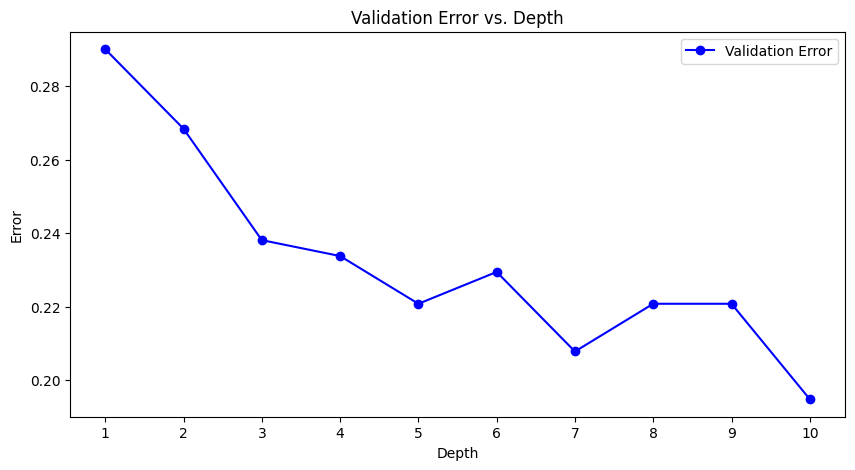

Best Depth: 10
Minimum Validation Error: 0.19480519480519476


In [91]:
depths =range(1,11)  # Depths from 1 to 30
# depths=[0.001,0.002,0.003,0.005,0.01,0.02,0.03,0.05,0.06,0.07,0.1,0.2,0.3,0.5]
# depths=[100,200,300,500,1000,2000,3000,5000]

# Initialize lists to store results
train_errors = []
val_errors = []
best_val_error = float('inf')
best_depth = None

# Iterate over different depths
for depth in depths:
    # Initialize the CatBoostClassifier
    model = CatBoostClassifier(
         iterations=1000,
    learning_rate=0.001,
    depth=depth,
    eval_metric='Accuracy',
    random_seed=28,
    verbose=100,
    # Additional hyperparameters
    l2_leaf_reg=3.0,             # L2 regularization term on weights
    bootstrap_type='Bayesian',   # Bootstrap type: 'Bayesian', 'Bernoulli', 'MVS'
   # subsample=0.8,               # Fraction of samples to use for each iteration, used for 'Bernoulli' bootstrap type
    colsample_bylevel=0.8,       # Fraction of features to use for each iteration
    grow_policy='Lossguide', # Tree growing policy: 'SymmetricTree', 'Depthwise', 'Lossguide'
    max_bin=254,                 # Max number of bins that feature values are bucketed in
    one_hot_max_size=10,         # Max number of unique values in a categorical feature to use one-hot encoding
    leaf_estimation_method='Gradient', # Leaf estimation method: 'Newton', 'Gradient'
   early_stopping_rounds=400 
        
    )
    
    # Prepare the Pool objects for training and validation data
    train_pool = Pool(X_train, y_train)
    val_pool = Pool(X_val, y_val)
    
    
    # Train the model
    model.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=False)
    
    # Make predictions on the validation set
    y_val_pred = model.predict(X_val)
    
    # Calculate validation accuracy
    val_accuracy = accuracy_score(y_val, y_val_pred)
    
    # Calculate validation error
    val_error = 1 - val_accuracy
    
    # Store errors
    val_errors.append(val_error)
    
    # Update the best validation error and corresponding depth
    if val_error < best_val_error:
        best_val_error = val_error
        best_depth = depth

# Plot validation errors as a function of depth
plt.figure(figsize=(10, 5))
plt.plot(depths, val_errors, marker='o', color='blue', label='Validation Error')
plt.xlabel('Depth')
plt.ylabel('Error')
plt.title('Validation Error vs. Depth')
plt.xticks(depths)
plt.legend()
plt.show()

print("Best Depth:", best_depth)
print("Minimum Validation Error:", best_val_error)

In [89]:
model1 = CatBoostClassifier(
         iterations=1000,
    learning_rate=0.001,
    depth=8,
    eval_metric='Accuracy',
    
    random_seed=28,
    verbose=100,
    # Additional hyperparameters
    l2_leaf_reg=3.0,             # L2 regularization term on weights
    bootstrap_type='Bayesian',   # Bootstrap type: 'Bayesian', 'Bernoulli', 'MVS'
   # subsample=0.8,               # Fraction of samples to use for each iteration, used for 'Bernoulli' bootstrap type
    colsample_bylevel=0.7,       # Fraction of features to use for each iteration
    grow_policy='Lossguide', # Tree growing policy: 'SymmetricTree', 'Depthwise', 'Lossguide'
    max_bin=254,                 # Max number of bins that feature values are bucketed in
    one_hot_max_size=10,         # Max number of unique values in a categorical feature to use one-hot encoding
    leaf_estimation_method='Gradient', # Leaf estimation method: 'Newton', 'Gradient'
#    early_stopping_rounds=300
    )
train_pool = Pool(X_train, y_train)
val_pool = Pool(X_val, y_val)
    
# Train the model
model1.fit(train_pool, eval_set=val_pool, use_best_model=True, plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.7727273	test: 0.6320346	best: 0.6320346 (0)	total: 19.1ms	remaining: 19.1s
100:	learn: 0.8409091	test: 0.7748918	best: 0.7965368 (11)	total: 1.8s	remaining: 16s
200:	learn: 0.8365801	test: 0.7489177	best: 0.7965368 (11)	total: 3.55s	remaining: 14.1s
300:	learn: 0.8398268	test: 0.7705628	best: 0.7965368 (11)	total: 5.29s	remaining: 12.3s
400:	learn: 0.8409091	test: 0.7619048	best: 0.7965368 (11)	total: 7.04s	remaining: 10.5s
500:	learn: 0.8474026	test: 0.7619048	best: 0.7965368 (11)	total: 8.8s	remaining: 8.76s
600:	learn: 0.8517316	test: 0.7619048	best: 0.7965368 (11)	total: 10.6s	remaining: 7.05s
700:	learn: 0.8582251	test: 0.7748918	best: 0.7965368 (11)	total: 12.6s	remaining: 5.36s
800:	learn: 0.8625541	test: 0.7705628	best: 0.7965368 (11)	total: 14.5s	remaining: 3.6s
900:	learn: 0.8679654	test: 0.7662338	best: 0.7965368 (11)	total: 16.4s	remaining: 1.8s
999:	learn: 0.8722944	test: 0.7619048	best: 0.7965368 (11)	total: 18.2s	remaining: 0us

bestTest = 0.7965367965
bestIt

In [92]:
y_val_pred_prob = model1.predict_proba(X_val)
y_val_pred = np.argmax(y_val_pred_prob, axis=1)
val_accuracy = accuracy_score(y_val, y_val_pred)
val_accuracy

0.7965367965367965

In [93]:
y_test_prob = model1.predict_proba(X_test)
y_test_pred = np.argmax(y_test_prob, axis=1)

In [94]:
test_predicted_class_probabilities = y_test_prob[np.arange(len(y_test_prob)), y_test_pred]

In [95]:
test_data['is_team1_winner_pred'] = y_test_pred
test_data['winner_id_pred'] = np.where(test_data['is_team1_winner_pred'] == 1, test_data['team1_id'], test_data['team2_id'])


In [96]:
primary_data['win_pred_team_id']=test_data['winner_id_pred']
primary_data['win_pred_score']=test_predicted_class_probabilities
primary_data['train_algorithm']="catboost"
primary_data['is_ensemble']="no"
primary_data['train_hps_trees']=1000
primary_data['train_hps_depth']=8
primary_data['train_hps_lr']=0.001

In [98]:
feature_importance = model1.get_feature_importance()


# Make sure feature_importance is a 1D array
if feature_importance.ndim != 1:
    raise ValueError("Feature importance array is not 1-dimensional")

# Get the indices of the top 10 features
top_10_indices = feature_importance.argsort()[-10:][::-1]

# Get the names of the top 10 features
top_10_features = [model1.feature_names_[index] for index in top_10_indices]
top_10_importance = [model1.get_feature_importance()[index] for index in top_10_indices]
print(top_10_features)
print(top_10_importance)


['team2_winp_team1_last15', 'team1_winp_team2_last15', 'team2_max_wickets_before_same_series', 'ground_avg_runs_last15', 'team1only_avg_runs_last15', 'team1_avg_bat_last5', 'team2_avg_bowl_last5', 'team2_avg_runs_last15', 'team1_max_total_runs_before_same_series', 'winp_team1_if_won_toss_last15']
[66.75231823597743, 9.091721223778762, 1.5722119032685753, 1.5088118670834054, 1.062384432009997, 0.9754458983358711, 0.96951754157698, 0.9289164587992974, 0.8636014963367532, 0.7523005007327717]


In [99]:
start_column_index = 9  # Column index to start inserting values
top_10_features = top_10_features[:10]  # Select the first 10 features

for i, column in enumerate(top_10_features):
    primary_data.iloc[:, start_column_index + i] = X_test[column]


In [100]:
primary_data

,match id,dataset_type,win_pred_team_id,win_pred_score,train_algorithm,is_ensemble,train_hps_trees,train_hps_depth,train_hps_lr,indep_feat_id1,indep_feat_id2,indep_feat_id3,indep_feat_id4,indep_feat_id5,indep_feat_id6,indep_feat_id7,indep_feat_id8,indep_feat_id9,indep_feat_id10
0,9272619,r2,33928,0.502025,catboost,no,1000,8,0.001,0.400000,60.0,7.0,154.115385,167.933333,20.166667,28.806452,158.733333,124.0,0.200000
1,9086958,r2,69,0.506412,catboost,no,1000,8,0.001,1.000000,0.0,0.0,142.833333,141.888889,32.125000,20.777778,153.933333,0.0,0.800000
2,9433654,r2,9701,0.505897,catboost,no,1000,8,0.001,1.000000,0.0,21.0,155.733333,178.800000,24.645161,24.692308,142.800000,261.0,0.500000
3,9097248,r2,22763,0.506470,catboost,no,1000,8,0.001,1.000000,0.0,0.0,142.500000,138.000000,18.157895,25.777778,129.333333,0.0,0.000000
4,9097234,r2,23841,0.500854,catboost,no,1000,8,0.001,0.000000,100.0,0.0,157.888017,155.800000,23.606061,19.885714,124.400000,0.0,0.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,9984162,r2,36014,0.502939,catboost,no,1000,8,0.001,0.500000,50.0,0.0,181.625000,181.400000,32.275862,37.000000,171.066667,0.0,0.300000
203,9984176,r2,30400,0.505427,catboost,no,1000,8,0.001,0.666667,40.0,0.0,168.033333,189.133333,37.000000,21.457143,155.066667,0.0,0.333333
204,9984183,r2,30428,0.502244,catboost,no,1000,8,0.001,0.000000,75.0,0.0,168.033333,185.666667,26.705882,36.840000,160.000000,0.0,0.000000
205,9984190,r2,30428,0.502988,catboost,no,1000,8,0.001,0.500000,50.0,0.0,157.933333,189.133333,37.000000,36.840000,160.000000,0.0,0.333333


In [101]:
csv_file_path = "2024_DS_Track_File1_The_Data Distrupters.csv"

# Save the DataFrame to a CSV file
primary_data.to_csv(csv_file_path, index=False)

In [102]:
train_data

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,winner,winner_id,toss winner,...,ground_25038_x_is_team1_won_toss,ground_25045_x_is_team1_won_toss,ground_25479_x_is_team1_won_toss,lighting_day match_x_is_team1_won_toss,lighting_day/night match_x_is_team1_won_toss,lighting_night match_x_is_team1_won_toss,ground_avg_wkts_last15,winp_team1_if_won_toss_last15,winp_team2_if_won_toss_last15,team2_winp_team1_last15
0,9331181,Ba,11283,9373356.0:7857520.0:4232164.0:4566540.0:329940...,Hl Ph,12634,3500958.0:4231751.0:2735081.0:2035102.0:369833...,Hl Ph,12634.0,Hl Ph,...,0,0,0,0,0,0,13.500000,0.600000,1.000000,0.500000
1,8797060,Ed,20,2089079.0:6139370.0:2076192.0:62432.0:2083409....,Wt Is,41,4690258.0:4069666.0:4230127.0:1942317.0:161392...,Ed,20.0,Wt Is,...,0,0,0,0,0,0,11.000000,0.500000,0.400000,0.500000
2,9433269,We,10576,3298427.0:2288789.0:7773338.0:3519011.0:368195...,Ne,8987,4003390.0:1749075.0:1626526.0:4172447.0:551672...,We,10576.0,Ne,...,0,0,0,0,0,0,14.066667,0.500000,0.333333,0.500000
3,9587073,Ga An Ws,36084,8127230.0:4690328.0:4069666.0:7960847.0:469018...,Bs Rs,36070,3462080.0:2436405.0:1798705.0:7550857.0:574247...,Ga An Ws,36084.0,Ga An Ws,...,0,0,0,1,0,0,14.166667,0.461538,0.428571,0.400000
4,9516457,Pb Ks,30407,8127181.0:197658.0:4239038.0:2398346.0:5053082...,Gt Ts,48341,1958683.0:7491224.0:8059029.0:4377610.0:225245...,Gt Ts,48341.0,Gt Ts,...,0,0,0,0,0,0,12.000000,0.428571,0.571429,1.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1150,9984162,Pb Ks,30407,7881719.0:8127181.0:2231928.0:2642751.0:505308...,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:305731...,NaN,NaN,Pb Ks,...,0,0,0,0,1,0,12.500000,0.300000,0.333333,0.500000
1151,9984176,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:811799...,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:506174...,NaN,NaN,Ss Hd,...,0,0,0,0,0,1,12.066667,0.333333,0.533333,0.666667
1152,9984183,Rl Cs Bu,30393,1776627.0:313809.0:7537004.0:5765934.0:2275195...,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:822842...,NaN,NaN,Rn Rs,...,0,0,0,0,0,0,12.066667,0.000000,0.466667,0.000000
1153,9984190,Ss Hd,36014,3710090.0:7491294.0:3127354.0:4203499.0:305731...,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:822842...,NaN,NaN,Rn Rs,...,0,0,0,0,0,0,13.666667,0.333333,0.466667,0.500000


In [103]:
test_data

,match id,team1,team1_id,team1_roster_ids,team2,team2_id,team2_roster_ids,toss winner,toss decision,venue,...,ground_25479_x_is_team1_won_toss,lighting_day match_x_is_team1_won_toss,lighting_day/night match_x_is_team1_won_toss,lighting_night match_x_is_team1_won_toss,ground_avg_wkts_last15,winp_team1_if_won_toss_last15,winp_team2_if_won_toss_last15,team2_winp_team1_last15,is_team1_winner_pred,winner_id_pred
0,9272619,Me Ss,33949,4003390.0:7960994.0:3901078.0:2669316.0:373710...,Ht Hs,33928,5843200.0:4223883.0:4655384.0:6249256.0:216159...,Ht Hs,field,Be Ol Ht,...,0,0,0,0,12.692308,0.200000,0.400000,0.400000,0,33928
1,9086958,Na,209,5836452.0:8246468.0:7500324.0:3065502.0:363350...,Si La,69,7200598.0:4403531.0:3260564.0:2420760.0:239834...,Si La,field,GA Sm Sh Gg Va,...,0,0,0,0,13.000000,0.800000,0.533333,1.000000,0,69
2,9433654,Gn,7573,5164844.0:8110185.0:2979857.0:1722048.0:270743...,St,9701,6139370.0:7694581.0:3294444.0:3239102.0:481700...,St,field,Sa Gs Cf,...,0,0,0,0,12.266667,0.500000,0.600000,1.000000,0,9701
3,9097248,Ks,22784,3496933.0:4167673.0:4160316.0:1863889.0:310883...,Ds,22763,3399745.0:4898074.0:3782225.0:2252452.0:223190...,Ks,bat,St Gs Pk Pt Eh,...,0,1,0,0,10.000000,0.000000,0.750000,1.000000,0,22763
4,9097234,Ws,23841,4166882.0:3009215.0:1963443.0:3252927.0:417185...,Ts,23750,2654014.0:2667223.0:3406717.0:3057312.0:415964...,Ts,field,St Gs Pk Pt Eh,...,0,0,0,0,0.000000,0.250000,1.000000,0.000000,1,23841
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,9984162,Pb Ks,30407,7881719.0:8127181.0:2231928.0:2642751.0:505308...,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:305731...,Pb Ks,bat,Rv Gi Il Sm Ul Hd,...,0,0,1,0,12.500000,0.300000,0.333333,0.500000,0,36014
203,9984176,Ss Hd,36014,3710090.0:7491294.0:3127354.0:8228485.0:811799...,Ka Kt Rs,30400,6818622.0:1613919.0:5959834.0:4497646.0:506174...,Ss Hd,bat,Na Mi Sm Ad,...,0,0,0,1,12.066667,0.333333,0.533333,0.666667,0,30400
204,9984183,Rl Cs Bu,30393,1776627.0:313809.0:7537004.0:5765934.0:2275195...,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:822842...,Rn Rs,field,Na Mi Sm Ad,...,0,0,0,0,12.066667,0.000000,0.466667,0.000000,0,30428
205,9984190,Ss Hd,36014,3710090.0:7491294.0:3127354.0:4203499.0:305731...,Rn Rs,30428,8058959.0:3294444.0:2981614.0:7556051.0:822842...,Rn Rs,field,MA Cm Sm Ck Ci,...,0,0,0,0,13.666667,0.333333,0.466667,0.500000,0,30428
